In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from deep_bsde_GBM_solver import BSDEsolver, Model_GBM, fbsde, make_gbm_basket_equation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def random_corr(d, rng):
    """
    Generate a random d x d correlation matrix.
    """
    A = rng.normal(size=(d, d))
    covs = A @ A.T                     # positive semidefinite
    variances = np.sqrt(np.diag(covs))
    corr = covs / np.outer(variances, variances)       # normalise diagonal to 1
    return corr


def random_prices(d, rng):
    """
    Generate 'd' random initial stock prices. (chosen uniformly in [0,1])
    """
    return rng.uniform(size=d)

def random_weights(d, rng):
    """
    Generate 'd' random weights (sum=1, unfiormly chosen) which are the weights of the basket for the option.
    """
    pre_weights = rng.uniform(size=d)
    weights = pre_weights / np.sum(pre_weights)
    return weights

def generate_price_estimate(S0, r, q, sigma, corr, T, K, weights, n_paths, rng):
    """
    Generates a monte carlo price estimate of a basket european call option for the given option parameters,
    using n_paths samples
    """
    L = np.linalg.cholesky(corr)
    
    Xi = rng.standard_normal(size=(n_paths, d))
    Z  = Xi @ L.T

    drift = (r - q - 0.5 * sigma**2) * T        # (d,)
    volT  = sigma * np.sqrt(T)                  # (d,)
    ST = S0 * np.exp(drift + Z * volT)          # (n_paths, d)

    basket = ST @ weights
    payoff = np.maximum(basket - K, 0)
    price_sims = np.exp(- r * T) * payoff
    est_price = price_sims.mean()
    std = price_sims.std(ddof=1) / np.sqrt(n_paths)
    ci95 = (est_price - 1.96*std, est_price + 1.96*std)

    print(f'estimated price: {est_price:.4g}, 95% confidence interval: ({ci95[0]:.4g}, {ci95[1]:.4g})') 
    return est_price, std, ci95

Monte Carlo Simulation for random basket european call option price

In [3]:
rng = np.random.default_rng(0)
d = 1
x_0 = random_prices(d, rng)        # initial prices
K  = 0.2        # strike price
T  = 1.0        # maturity 
r  = 0.02       # risk-free rate 
q  = 0.02*random_prices(d, rng)       # dividend yield 
vol = 0.30*random_prices(d,rng)    # volatility 
corr = random_corr(d, rng)
weights = random_weights(d, rng)
n_paths = 10**7

call_price, _, _ = generate_price_estimate(x_0, r, q, vol, corr, T, K, weights, n_paths, rng)

estimated price: 0.4375, 95% confidence interval: (0.4375, 0.4375)


FBSDE system for basket European Call option:

$$ X_t = S_t \in \mathbb{R}^d, \ dS_t^{(i)} = (r-q^{(i)})S_t^{(i)} dt + \sigma^{(i)} S_t^{(i)} dW_t^{(i)}, \ \ S_0 = x_0 $$

$$ Y_t = V(t, S^{(1)}_t , \cdots, S^{(d)}_t) \in \mathbb{R}, \ dY_t = rY_tdt + Z_t \cdot dW_t, \ \ Y_T = (w^TS_T - K)^+, \ \ Z_t = \left( \sigma^{(1)} S_t^{(1)} V_{S^{(1)}}, \cdots , \sigma^{(d)} S_t^{(d)} V_{S^{(d)}} \right) $$

Deep BSDE Simulation:

Computed Option price: 0.46310
Monte Carlo Estimated Price: 0.43749
Error: 0.02561, 5.85326%


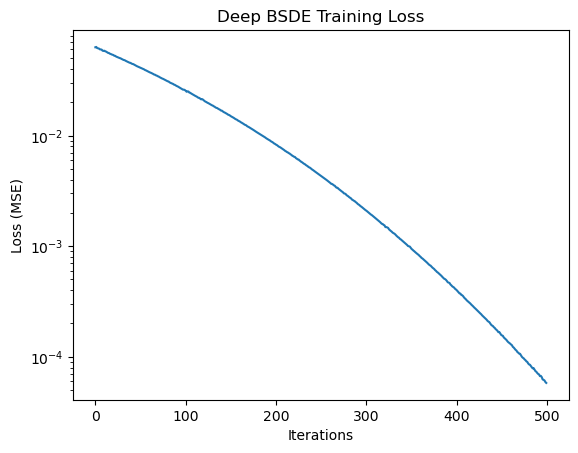

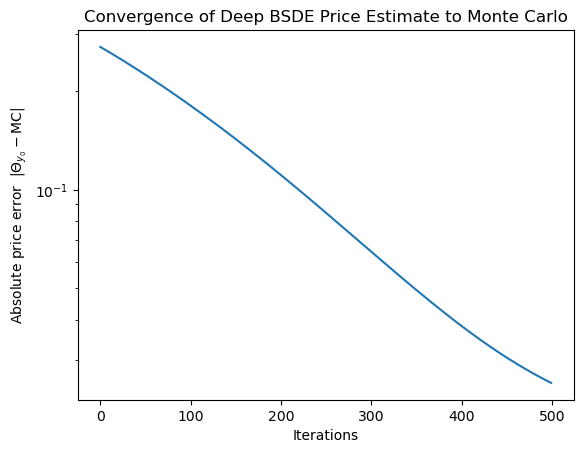

In [4]:
torch.manual_seed(0)
np.random.seed(0)

dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = d, 1, d, 11, 100, 500, 500

equation = make_gbm_basket_equation(x_0, r, q, vol, corr, K, weights, T, d, batch_size)

bsde_solver = BSDEsolver(equation, dim_h)
loss_data, y0_data = bsde_solver.train(batch_size, N, itr)

print(f'Computed Option price: {y0_data[-1]:.5f}')
print(f'Monte Carlo Estimated Price: {call_price:.5f}')
print(f'Error: {np.abs(y0_data[-1] - call_price):.5f}, {np.abs(y0_data[-1] - call_price)/call_price * 100:.5f}%')

fig1, ax1 = plt.subplots()
ax1.semilogy(loss_data)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss (MSE)")
ax1.set_title("Deep BSDE Training Loss")


err = np.abs(np.asarray(y0_data) - call_price)
fig2, ax2 = plt.subplots()
ax2.semilogy(err)
ax2.set_xlabel("Iterations")
ax2.set_ylabel(r"Absolute price error  $|\Theta_{y_0} - \text{MC}|$")
ax2.set_title("Convergence of Deep BSDE Price Estimate to Monte Carlo")

plt.show()

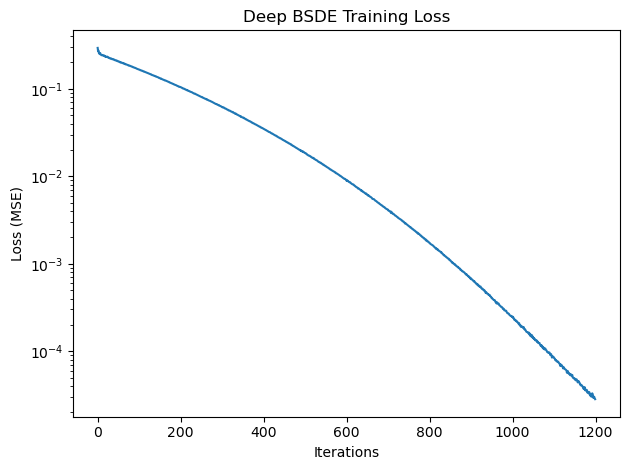

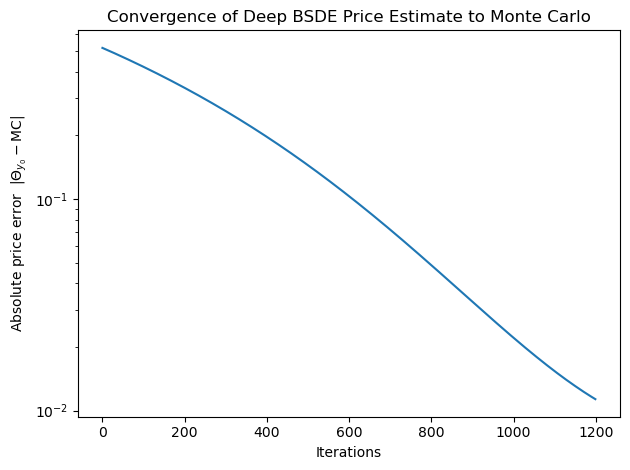

In [116]:

fig1, ax1 = plt.subplots()
ax1.semilogy(loss_data)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss (MSE)")
ax1.set_title("Deep BSDE Training Loss")


err = np.abs(np.asarray(y0_data) - call_price)
fig2, ax2 = plt.subplots()
ax2.semilogy(err)
ax2.set_xlabel("Iterations")
ax2.set_ylabel(r"Absolute price error  $|\Theta_{y_0} - \text{MC}|$")
ax2.set_title("Convergence of Deep BSDE Price Estimate to Monte Carlo")

plt.show()